# In this notebook we will train the random forest model

In [2]:
print(summary.to_string(index=False))


 Year  HorizonH   Bin  Precision  Recall    F1  Samples
 2016         1 0.005      0.807   0.335 0.301    80654
 2016         1 0.010      0.315   0.333 0.324    80654
 2016         1 0.020      0.330   0.333 0.332    80654
 2016         2 0.005      0.425   0.338 0.287    80653
 2016         2 0.010      0.629   0.334 0.314    80653
 2016         2 0.020      0.325   0.333 0.329    80653
 2016         4 0.005      0.409   0.378 0.353    80651
 2016         4 0.010      0.414   0.334 0.297    80651
 2016         4 0.020      0.312   0.333 0.322    80651
 2016        12 0.005      0.395   0.374 0.339    80643
 2016        12 0.010      0.369   0.366 0.341    80643
 2016        12 0.020      0.396   0.335 0.305    80643
 2018         1 0.005      0.592   0.335 0.295    63355
 2018         1 0.010      0.311   0.333 0.322    63355
 2018         1 0.020      0.329   0.333 0.331    63355
 2018         2 0.005      0.448   0.339 0.282    63354
 2018         2 0.010      0.624   0.334 0.311  

### 📊 Quick RF Baseline Results (macro-averaged)

| Year | HorizonH |   Bin   | Precision | Recall |   F1   | Samples |
|------|----------|---------|-----------|--------|--------|---------|
| 2016 |        1 | 0.005   |     0.807 |  0.335 |  0.301 |   80654 |
| 2016 |        1 | 0.010   |     0.315 |  0.333 |  0.324 |   80654 |
| 2016 |        1 | 0.020   |     0.330 |  0.333 |  0.332 |   80654 |
| 2016 |        2 | 0.005   |     0.425 |  0.338 |  0.287 |   80653 |
| 2016 |        2 | 0.010   |     0.629 |  0.334 |  0.314 |   80653 |
| 2016 |        2 | 0.020   |     0.325 |  0.333 |  0.329 |   80653 |
| 2016 |        4 | 0.005   |     0.409 |  0.378 |  0.353 |   80651 |
| 2016 |        4 | 0.010   |     0.414 |  0.334 |  0.297 |   80651 |
| 2016 |        4 | 0.020   |     0.312 |  0.333 |  0.322 |   80651 |
| 2016 |       12 | 0.005   |     0.395 |  0.374 |  0.339 |   80643 |
| 2016 |       12 | 0.010   |     0.369 |  0.366 |  0.341 |   80643 |
| 2016 |       12 | 0.020   |     0.396 |  0.335 |  0.305 |   80643 |
| 2018 |        1 | 0.005   |     0.592 |  0.335 |  0.295 |   63355 |
| 2018 |        1 | 0.010   |     0.311 |  0.333 |  0.322 |   63355 |
| 2018 |        1 | 0.020   |     0.329 |  0.333 |  0.331 |   63355 |
| 2018 |        2 | 0.005   |     0.448 |  0.339 |  0.282 |   63354 |
| 2018 |        2 | 0.010   |     0.624 |  0.334 |  0.311 |   63354 |
| 2018 |        2 | 0.020   |     0.323 |  0.333 |  0.328 |   63354 |
| 2018 |        4 | 0.005   |     0.391 |  0.368 |  0.338 |   63352 |
| 2018 |        4 | 0.010   |     0.422 |  0.334 |  0.291 |   63352 |
| 2018 |        4 | 0.020   |     0.309 |  0.333 |  0.321 |   63352 |
| 2018 |       12 | 0.005   |     0.363 |  0.346 |  0.279 |   63344 |
| 2018 |       12 | 0.010   |     0.352 |  0.352 |  0.320 |   63344 |
| 2018 |       12 | 0.020   |     0.379 |  0.334 |  0.298 |   63344 |
| 2020 |        1 | 0.005   |     0.388 |  0.335 |  0.292 |   45874 |
| 2020 |        1 | 0.010   |     0.310 |  0.333 |  0.321 |   45874 |
| 2020 |        1 | 0.020   |     0.329 |  0.333 |  0.331 |   45874 |
| 2020 |        2 | 0.005   |     0.449 |  0.344 |  0.290 |   45873 |
| 2020 |        2 | 0.010   |     0.287 |  0.333 |  0.309 |   45873 |
| 2020 |        2 | 0.020   |     0.322 |  0.333 |  0.327 |   45873 |
| 2020 |        4 | 0.005   |     0.415 |  0.377 |  0.346 |   45871 |
| 2020 |        4 | 0.010   |     0.418 |  0.334 |  0.287 |   45871 |
| 2020 |        4 | 0.020   |     0.307 |  0.333 |  0.320 |   45871 |
| 2020 |       12 | 0.005   |     0.341 |  0.340 |  0.328 |   45863 |
| 2020 |       12 | 0.010   |     0.359 |  0.346 |  0.319 |   45863 |
| 2020 |       12 | 0.020   |     0.465 |  0.335 |  0.296 |   45863 |
| 2022 |        1 | 0.005   |     0.462 |  0.336 |  0.292 |   28340 |
| 2022 |        1 | 0.010   |     0.309 |  0.333 |  0.321 |   28340 |
| 2022 |        1 | 0.020   |     0.329 |  0.333 |  0.331 |   28340 |
| 2022 |        2 | 0.005   |     0.439 |  0.345 |  0.290 |   28339 |
| 2022 |        2 | 0.010   |     0.287 |  0.333 |  0.309 |   28339 |
| 2022 |        2 | 0.020   |     0.321 |  0.333 |  0.327 |   28339 |
| 2022 |        4 | 0.005   |     0.399 |  0.360 |  0.312 |   28337 |
| 2022 |        4 | 0.010   |     0.251 |  0.333 |  0.286 |   28337 |
| 2022 |        4 | 0.020   |     0.306 |  0.333 |  0.319 |   28337 |
| 2022 |       12 | 0.005   |     0.347 |  0.344 |  0.336 |   28329 |
| 2022 |       12 | 0.010   |     0.364 |  0.361 |  0.330 |   28329 |
| 2022 |       12 | 0.020   |     0.296 |  0.335 |  0.307 |   28329 |


In [ ]:
# ───────────────────────────── CONFIG & IMPORTS ─────────────────────────────
import warnings, shap, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # prevent GPU errors for SHAP

# ────────────────────────────── CONFIG  ─────────────────────────────────────
DATA_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2016_final.csv")
HORIZON   = 4
BINS      = [-np.inf, -0.005, 0.005, np.inf]
TEST_SIZE = 0.2
RAND_SEED = 42

RF_KWARGS = dict(
    n_estimators = 200,
    max_depth    = None,
    max_features = "sqrt",
    class_weight = "balanced",
    n_jobs       = -1,
    random_state = RAND_SEED
)

# ─────────────────────── LOAD + LABEL ──────────────────────────────────────
df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df.dropna(subset=["y"], inplace=True)

# ─────────────────────── TRAIN/TEST SPLIT ──────────────────────────────────
X = df.drop(columns=["date", "rel_ret", "y"])
y = df["y"].astype(int)

split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ─────────────────────── MODEL SETUP + TRAIN ───────────────────────────────
num_cols = X_train.select_dtypes("number").columns
prep = ColumnTransformer([("num", "passthrough", num_cols)], remainder="drop", verbose_feature_names_out=False)]]

model = Pipeline([("prep", prep), ("rf", RandomForestClassifier(**RF_KWARGS))])
model.fit(X_train, y_train)

print("\n📊 Hold-out classification report:")
print(classification_report(y_test, model.predict(X_test), digits=3, zero_division=0))

# ─────────────────────── SHAP ON 200 SAMPLES PER YEAR ──────────────────────
df["year"] = df["date"].dt.year
sampled_df = pd.concat([
    df[df["year"] == year].sample(n=200, random_state=RAND_SEED)
    for year in df["year"].unique()
    if len(df[df["year"] == year]) >= 200
])

X_shap = sampled_df.drop(columns=["date", "rel_ret", "y", "year"])
prepped_X = model.named_steps["prep"].transform(X_shap)
rf_model  = model.named_steps["rf"]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(prepped_X)

print(f"✅ SHAP input shape: {prepped_X.shape}, Classes: {len(shap_values)}")

# Summary plot — comment this if you don’t want graph immediately
shap.summary_plot(shap_values, features=X_shap, feature_names=num_cols.tolist())



📊 Hold-out classification report:
              precision    recall  f1-score   support

           0      0.276     0.238     0.256      3249
           1      0.609     0.840     0.706      9224
           2      0.341     0.057     0.098      3658

    accuracy                          0.541     16131
   macro avg      0.409     0.378     0.353     16131
weighted avg      0.481     0.541     0.478     16131




📊 20 % hold-out metrics:
              precision    recall  f1-score   support

           0      0.255     0.601     0.358      3249
           1      0.711     0.529     0.607      9224
           2      0.311     0.136     0.189      3658

    accuracy                          0.454     16131
   macro avg      0.426     0.422     0.385     16131
weighted avg      0.528     0.454     0.462     16131



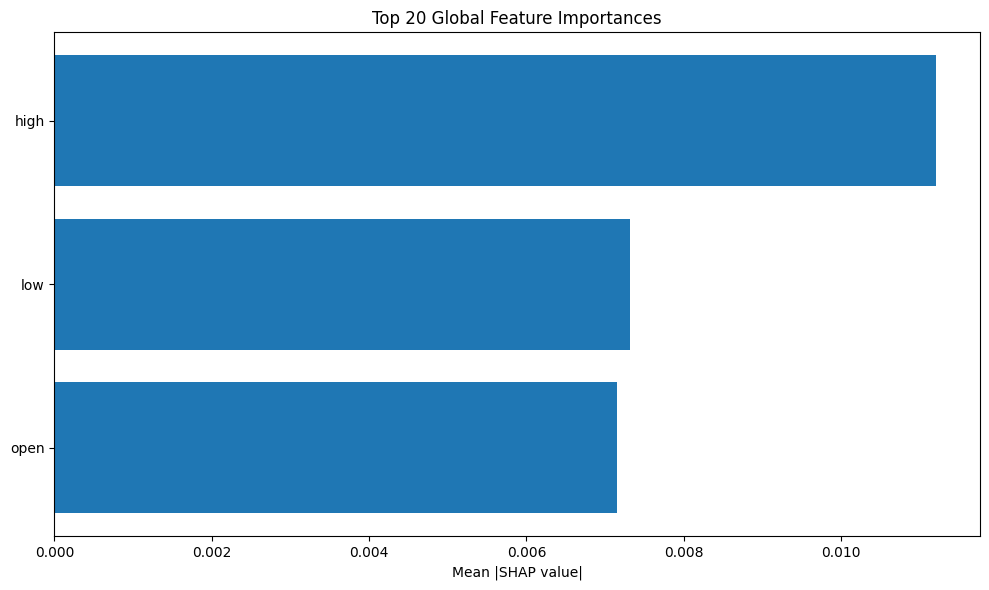

In [3]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
import shap

warnings.filterwarnings("ignore")

# ╭─ CONFIG ─╮
DATA_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2016_final.csv")
HORIZON = 4
BIN_WIDTH = 0.005
TEST_SIZE = 0.20
RAND_SEED = 42
MAX_TRAIN_ROWS = 100_000
SHAP_PER_YEAR = 120

RF_KWARGS = dict(
    n_estimators=100, max_depth=12, max_features="sqrt", class_weight="balanced",
    max_samples=0.6, n_jobs=-1, random_state=RAND_SEED
)

# ─── LOAD & LABEL ───
df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
if len(df) > MAX_TRAIN_ROWS:
    df = df.iloc[:: int(len(df) / MAX_TRAIN_ROWS)]

bins = [-np.inf, -BIN_WIDTH, BIN_WIDTH, np.inf]
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"] = pd.cut(df["rel_ret"], bins=bins, labels=False, right=False)
df.dropna(subset=["y"], inplace=True)

X = df.drop(columns=["date", "rel_ret", "y"])
y = df["y"].astype(int)

split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ─── PIPELINE ───
num_cols = X_train.select_dtypes("number").columns
prep = ColumnTransformer([("num", "passthrough", num_cols)], remainder="drop", verbose_feature_names_out=False)
model = Pipeline([("prep", prep), ("rf", RandomForestClassifier(**RF_KWARGS))])
model.fit(X_train, y_train)

print("\n📊 20 % hold-out metrics:")
print(classification_report(y_test, model.predict(X_test), digits=3, zero_division=0))

# ─── LIGHT SHAP SAMPLE ───
df["year"] = df["date"].dt.year
df["y_lbl"] = y
samples = []
for yr, g in df.groupby("year", observed=True):
    n = min(SHAP_PER_YEAR, len(g))
    g_sample = (g.groupby("y_lbl", group_keys=False, observed=True)
                  .apply(lambda d: resample(d, n_samples=int(n * len(d) / len(g)),
                                            replace=False, random_state=RAND_SEED)))
    samples.append(g_sample)

X_shap_df = pd.concat(samples).drop(columns=["date", "rel_ret", "y_lbl", "year"])
prepped_X = model.named_steps["prep"].transform(X_shap_df)

feat_names = model.named_steps["prep"].get_feature_names_out()
rf_model = model.named_steps["rf"]

# Force CPU-only SHAP explainability
explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent", approximate=True)
shap_list = explainer.shap_values(prepped_X, check_additivity=False)

# ─── GLOBAL IMPORTANCE BAR PLOT ───
mean_abs = np.mean([np.abs(s) for s in shap_list], axis=0)
global_importance = np.mean(mean_abs, axis=0)
sorted_idx = np.argsort(global_importance)[::-1]
sorted_names = np.array(feat_names)[sorted_idx]
sorted_values = global_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:20][::-1], sorted_values[:20][::-1])
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Global Feature Importances")
plt.tight_layout()
plt.show()


In [9]:
# ───────────────────── CONFIG ──────────────────────
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.inspection import permutation_importance

DATA_PATH  = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                  r"\Stock-Market-Prediction\data\processed"
                  r"\gemini_btc_data_final_version_with_features_2016_final.csv")

HORIZON    = 4                        # hours forward you want to predict
BINS       = [-np.inf, -0.005, 0.005, np.inf]   # three-way ↓ / flat / ↑
TEST_SIZE  = 0.20                     # last 20 % = test
RAND_SEED  = 42

RF_PARAMS  = dict(                    # quick but decent forest
    n_estimators = 300,
    max_depth    = None,
    max_features = "sqrt",
    class_weight = "balanced",
    n_jobs       = -1,
    random_state = RAND_SEED,
)
# ───────────────────── LOAD & LABEL ──────────────────────
warnings.filterwarnings("ignore")

df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df.dropna(subset=["y"], inplace=True)

X = df.drop(columns=["date", "rel_ret", "y"])
y = df["y"].astype(int)

# ───────────────────── CHRONOLOGICAL SPLIT ──────────────
split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ───────────────────── TRAIN & REPORT ───────────────────
rf = RandomForestClassifier(**RF_PARAMS)
rf.fit(X_train, y_train)

print(f"\n📊  Hold-out ({int(TEST_SIZE*100)} %) macro report:")
print(classification_report(y_test, rf.predict(X_test),
                            digits=3, zero_division=0))

# ───────────────────── FEATURE IMPORTANCE ───────────────
feat_names = X.columns.tolist()

# 1) Gini / impurity importance
gini_imp = (pd.DataFrame({"Feature": feat_names,
                          "Gini_score": rf.feature_importances_})
              .sort_values("Gini_score", ascending=False)
              .reset_index(drop=True))
gini_imp["Gini rank"] = np.arange(1, len(gini_imp)+1)

# 2) Permutation importance (macro-F1 drop)
perm = permutation_importance(
           rf, X_test, y_test,
           scoring=make_scorer(f1_score, average="macro"),
           n_repeats=5, random_state=RAND_SEED, n_jobs=-1)
perm_imp = (pd.DataFrame({"Feature": feat_names,
                          "Perm_score": perm.importances_mean})
              .sort_values("Perm_score", ascending=False)
              .reset_index(drop=True))
perm_imp["Perm rank"] = np.arange(1, len(perm_imp)+1)

# 3) Merge the two views into one dashboard
full_imp = (gini_imp.merge(perm_imp, on="Feature", how="outer")
                     .loc[:, ["Feature",
                              "Gini rank", "Gini_score",
                              "Perm rank", "Perm_score"]]
                     .sort_values("Perm rank")
                     .reset_index(drop=True))

# ───────────────────── DISPLAY ALL FEATURES ─────────────
pd.set_option("display.max_rows", None,
              "display.float_format", lambda v: f"{v:10.4g}")
print("\n🔍 Combined importance ranking (every feature):")
print(full_imp.to_string(index=False))



📊  Hold-out (20 %) macro report:
              precision    recall  f1-score   support

           0      0.273     0.226     0.247      3249
           1      0.608     0.848     0.708      9224
           2      0.340     0.053     0.091      3658

    accuracy                          0.542     16131
   macro avg      0.407     0.376     0.349     16131
weighted avg      0.480     0.542     0.475     16131


🔍 Combined importance ranking (every feature):
         Feature  Gini rank  Gini_score  Perm rank  Perm_score
              tr          4     0.05405          1      0.0242
          atr_14          3     0.05884          2     0.02261
      Volume BTC          5     0.05348          3     0.02009
            high         17     0.04176          4     0.01238
      band_width          1     0.06914          5    0.009333
price_above_ma50          6     0.04952          6    0.007758
           close         15     0.04243          7    0.007549
             low         19     0

In [ ]:
# ───────────────────── CONFIG ──────────────────────
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.inspection import permutation_importance

DATA_PATH  = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                  r"\Stock-Market-Prediction\data\processed"
                  r"\gemini_btc_data_final_version_with_features_2016_final.csv")

HORIZON    = 4                        # hours forward you want to predict
BINS       = [-np.inf, -0.005, 0.005, np.inf]   # three-way ↓ / flat / ↑
TEST_SIZE  = 0.20                     # last 20 % = test
RAND_SEED  = 40

RF_PARAMS  = dict(
    n_estimators = 300,
    max_depth    = None,
    max_features = "sqrt",
    class_weight = "balanced",
    n_jobs       = -1,
    random_state = RAND_SEED,
)

# ───────────────────── LOAD & LABEL ──────────────────────
warnings.filterwarnings("ignore")

df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df.dropna(subset=["y"], inplace=True)

# Drop open, high, low
drop_cols = ["date", "rel_ret", "y", "open", "high", "low",'macd_line']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"].astype(int)

# ───────────────────── CHRONOLOGICAL SPLIT ──────────────
split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ───────────────────── TRAIN & REPORT ───────────────────
rf = RandomForestClassifier(**RF_PARAMS)
rf.fit(X_train, y_train)

print(f"\n📊  Hold-out ({int(TEST_SIZE*100)} %) macro report:")
print(classification_report(y_test, rf.predict(X_test),
                            digits=3, zero_division=0))

# ───────────────────── FEATURE IMPORTANCE ───────────────
feat_names = X.columns.tolist()

# 1) Gini importance
gini_imp = (pd.DataFrame({"Feature": feat_names,
                          "Gini_score": rf.feature_importances_})
              .sort_values("Gini_score", ascending=False)
              .reset_index(drop=True))
gini_imp["Gini rank"] = np.arange(1, len(gini_imp)+1)

# 2) Permutation importance
perm = permutation_importance(
           rf, X_test, y_test,
           scoring=make_scorer(f1_score, average="macro"),
           n_repeats=5, random_state=RAND_SEED, n_jobs=-1)
perm_imp = (pd.DataFrame({"Feature": feat_names,
                          "Perm_score": perm.importances_mean})
              .sort_values("Perm_score", ascending=False)
              .reset_index(drop=True))
perm_imp["Perm rank"] = np.arange(1, len(perm_imp)+1)

# 3) Combine
full_imp = (gini_imp.merge(perm_imp, on="Feature", how="outer")
                     .loc[:, ["Feature",
                              "Gini rank", "Gini_score",
                              "Perm rank", "Perm_score"]]
                     .sort_values("Perm rank")
                     .reset_index(drop=True))

# ───────────────────── DISPLAY ALL FEATURES ─────────────
pd.set_option("display.max_rows", None,
              "display.float_format", lambda v: f"{v:10.4g}")
print("\n🔍 Combined importance ranking (every feature):")
print(full_imp.to_string(index=False))



📊  Hold-out (20 %) macro report:
              precision    recall  f1-score   support

           0      0.272     0.176     0.213      3249
           1      0.606     0.874     0.716      9224
           2      0.381     0.075     0.126      3658

    accuracy                          0.552     16131
   macro avg      0.420     0.375     0.352     16131
weighted avg      0.488     0.552     0.481     16131


🔍 Combined importance ranking (every feature):
         Feature  Gini rank  Gini_score  Perm rank  Perm_score
              tr          5     0.06286          1     0.03223
          atr_14          4     0.06718          2     0.02571
      Volume BTC          6     0.06219          3     0.02408
      band_width          1     0.08162          4     0.02247
price_above_ma50          7     0.05936          5     0.01435
          boll_b         15     0.04908          6     0.00738
     macd_signal         10     0.05798          7    0.006785
    ret_over_atr         14     0

In [8]:
"""
Fast hyper-parameter sweep for RandomForestClassifier
   • successive-halving on n_estimators   (200 → 600 → 1200)
   • optimises weighted F0.5
   • ~10 min on 4 logical cores
"""

# ────────── imports ──────────
from pathlib import Path
import warnings, numpy as np, pandas as pd

from sklearn.experimental import enable_halving_search_cv   # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer, classification_report
from scipy.stats import randint, uniform

# ────────── data (same as before) ──────────
DATA_PATH = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)

HORIZON  = 4
BINS     = [-np.inf, -0.005, 0.005, np.inf]
TEST_SZ  = 0.20
SEED     = 40

warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df = (df.dropna(subset=["y", "rel_ret"]).reset_index(drop=True))
df["y"] = df["y"].astype("int8")

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"]

split  = int(len(df) * (1 - TEST_SZ))
X_tr, X_te = X.iloc[:split], X.iloc[split:]
y_tr, y_te = y.iloc[:split], y.iloc[split:]

# ────────── precision-heavy scorer ──────────
f05_weighted = make_scorer(
    fbeta_score, beta=0.5, average="weighted", zero_division=0
)

# ────────── parameter distributions  (NOTICE: no n_estimators) ──────────
param_dist = {
    "max_depth":         randint(5, 60),
    "max_features":      uniform(0.2, 0.8),
    "min_samples_split": randint(2, 16),
    "min_samples_leaf":  randint(1, 6),
    "bootstrap":         [True, False],
    "class_weight":      ["balanced", "balanced_subsample"],
}

# ────────── halving random search ──────────
base_rf = RandomForestClassifier(
    n_jobs=-1, random_state=SEED
)

search = HalvingRandomSearchCV(
    estimator           = base_rf,
    param_distributions = param_dist,
    scoring             = f05_weighted,
    resource            = "n_estimators",   # RF will grow more trees each stage
    min_resources       = 200,
    max_resources       = 1200,
    factor              = 3,
    cv                  = StratifiedKFold(
                              n_splits=3, shuffle=True, random_state=SEED),
    random_state        = SEED,
    n_jobs              = -1,
    verbose             = 1,
)

np.random.seed(SEED)
search.fit(X_tr, y_tr)

print(f"\n Best CV F0.5: {search.best_score_:6.4f}")
print("Best hyper-parameters:\n", search.best_params_)

# ────────── evaluate on unseen data ──────────
best_rf = search.best_estimator_
y_pred  = best_rf.predict(X_te)

print("\n Hold-out report:")
print(classification_report(y_te, y_pred, digits=3, zero_division=0))
print("Weighted F0.5 on hold-out:",
      fbeta_score(y_te, y_pred, beta=0.5,
                  average="weighted", zero_division=0))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 200
max_resources_: 1200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 200
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 600
Fitting 3 folds for each of 2 candidates, totalling 6 fits

 Best CV F0.5: 0.5623
Best hyper-parameters:
 {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 57, 'max_features': np.float64(0.5282172483721086), 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 600}

 Hold-out report:
              precision    recall  f1-score   support

           0      0.255     0.474     0.331      3249
           1      0.675     0.596     0.633      9224
           2      0.303     0.160     0.209      3658

    accuracy                          0.473     16131
   macro avg      0.411     0.410     0.391     16131
weighted avg      0.506     0.473     0.476     16131

W

In [9]:
"""
Binary-direction model (price ↑ vs ↓) with a quick HalvingRandomSearchCV
-----------------------------------------------------------------------
• Target: will the close price be HIGHER (class 1) or LOWER/UNCHANGED
  (class 0) after HORIZON bars?
• Optimises weighted F0.5 (precision 4× recall).
• Same 10-min budget on a 4-core machine.
"""

# ────────── imports ──────────
from pathlib import Path
import warnings, numpy as np, pandas as pd

from sklearn.experimental import enable_halving_search_cv   # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer, classification_report
from scipy.stats import randint, uniform

# ────────── paths & basic params ──────────
DATA_PATH = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)

HORIZON  = 4          # bars ahead
TEST_SZ  = 0.20
SEED     = 40

# ────────── load & label ──────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]

# class 1 = price up (or exactly flat), class 0 = price down
df["y"] = (df["rel_ret"] >= 0).astype("int8")

# remove bars without a future price (last HORIZON rows)
df = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"]

# ────────── chronological split ──────────
cut = int(len(df) * (1 - TEST_SZ))
X_tr, X_te = X.iloc[:cut], X.iloc[cut:]
y_tr, y_te = y.iloc[:cut], y.iloc[cut:]

# ────────── precision-heavy scorer ──────────
f05_weighted = make_scorer(
    fbeta_score, beta=0.5, average="weighted", zero_division=0
)

# ────────── parameter distributions (no n_estimators!) ──────────
param_dist = {
    "max_depth":         randint(5, 60),
    "max_features":      uniform(0.2, 0.8),
    "min_samples_split": randint(2, 16),
    "min_samples_leaf":  randint(1, 6),
    "bootstrap":         [True, False],
    "class_weight":      ["balanced", "balanced_subsample"],
}

# ────────── halving random search ──────────
base_rf = RandomForestClassifier(
    n_jobs=-1, random_state=SEED
)

search = HalvingRandomSearchCV(
    estimator           = base_rf,
    param_distributions = param_dist,
    scoring             = f05_weighted,
    resource            = "n_estimators",      # 200 → 600 → 1200
    min_resources       = 200,
    max_resources       = 1200,
    factor              = 3,
    cv                  = StratifiedKFold(
                              n_splits=3, shuffle=True, random_state=SEED),
    random_state        = SEED,
    n_jobs              = -1,
    verbose             = 1,
)

np.random.seed(SEED)
search.fit(X_tr, y_tr)

print(f"\n  Best CV weighted-F0.5: {search.best_score_:6.4f}")
print("Best hyper-parameters:\n", search.best_params_)

# ────────── evaluate on hold-out ──────────
best_rf = search.best_estimator_
y_pred  = best_rf.predict(X_te)

print("\n Hold-out classification report:")
print(classification_report(y_te, y_pred, digits=3, zero_division=0))
print("Weighted F0.5 on hold-out:",
      fbeta_score(y_te, y_pred, beta=0.5,
                  average="weighted", zero_division=0))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 200
max_resources_: 1200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 200
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 600
Fitting 3 folds for each of 2 candidates, totalling 6 fits

  Best CV weighted-F0.5: 0.6095
Best hyper-parameters:
 {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 57, 'max_features': np.float64(0.5282172483721086), 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 600}

 Hold-out classification report:
              precision    recall  f1-score   support

           0      0.500     0.684     0.578      7808
           1      0.548     0.360     0.434      8323

    accuracy                          0.517     16131
   macro avg      0.524     0.522     0.506     16131
weighted avg      0.525     0.517     0.504     16131

Weighted F0.5 on hold-out: 0.5

# Final testing

In [10]:
# ░░░░░░░░░░░░░░  RANDOM-FOREST BTC DIRECTION MODEL  ░░░░░░░░░░░░░░
#   • labels: 1 = price ≥ current close after HORIZON bars, else 0
#   • metric: weighted F0.5  (precision ×4 recall)
#   • runs:   any number of hyper-param dicts in RUNS at the bottom
# ──────────────────────────────────────────────────────────────────
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold

# ────────────────  GLOBAL CONFIG  ────────────────
DATA_PATH = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)
HORIZON    = 4           # bars ahead for the target
TEST_SIZE  = 0.20        # 20 % hold-out (chronological split)
RAND_SEED  = 42

# columns we never feed to the model
DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# precision-heavy scorer for later CV use
F05_WEIGHTED = make_scorer(
    fbeta_score, beta=0.5, average="weighted", zero_division=0
)

# ────────────────  DATA PIPELINE  ────────────────
def load_data(path: Path, horizon: int):
    """Return X, y, keeping chronological order."""
    df = (pd.read_csv(path, parse_dates=["date"])
            .sort_values("date"))

    # future return
    df["rel_ret"] = (df["close"].shift(-horizon) - df["close"]) / df["close"]

    # binary target: up/flat = 1, down = 0
    df["y"] = (df["rel_ret"] >= 0).astype("int8")

    # drop rows without future price (last `horizon`)
    df = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

    X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
    y = df["y"]
    return X, y

def chrono_split(X, y, test_frac: float):
    """Chronological train/hold-out split."""
    cut = int(len(X) * (1 - test_frac))
    return X.iloc[:cut], X.iloc[cut:], y.iloc[:cut], y.iloc[cut:]

def eval_on_holdout(model, X_te, y_te, *, label: str):
    y_pred = model.predict(X_te)
    f05 = fbeta_score(y_te, y_pred, beta=0.5,
                      average="weighted", zero_division=0)
    print(f"\n──── Run: {label} ────")
    print(classification_report(y_te, y_pred, digits=3, zero_division=0))
    print("Weighted F0.5:", f05)

# ────────────────  TRAINING LOOP  ────────────────
def run_forest(X_tr, y_tr, X_te, y_te, params: dict, label: str):
    rf = RandomForestClassifier(
            n_jobs=-1,
            random_state=RAND_SEED,
            **params
    ).fit(X_tr, y_tr)
    eval_on_holdout(rf, X_te, y_te, label=label)

# ────────────────  MAIN  ────────────────
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(RAND_SEED)

    X, y = load_data(DATA_PATH, HORIZON)
    X_tr, X_te, y_tr, y_te = chrono_split(X, y, TEST_SIZE)

    # ---- DEFINE THE RUNS YOU WANT TO TRY -------------------------
    RUNS = {
        "best_halving": {          # ← your optimal set
            "bootstrap": False,
            "class_weight": "balanced",
            "max_depth": 57,
            "max_features": 0.5282172483721086,
            "min_samples_leaf": 5,
            "min_samples_split": 6,
            "n_estimators": 600
        },
        # Example alt-runs (edit / extend as you like) -------------
        "light_forest": {          # fewer trees, shallower
            "bootstrap": True,
            "class_weight": None,
            "max_depth": 25,
            "max_features": 0.6,
            "min_samples_leaf": 2,
            "min_samples_split": 4,
            "n_estimators": 300
        },
        "deep_bal_sub": {          # deeper & subsample weighting
            "bootstrap": False,
            "class_weight": "balanced_subsample",
            "max_depth": 80,
            "max_features": 0.4,
            "min_samples_leaf": 1,
            "min_samples_split": 2,
            "n_estimators": 800
        },
    }
    # --------------------------------------------------------------

    for label, params in RUNS.items():
        run_forest(X_tr, y_tr, X_te, y_te, params, label)



──── Run: best_halving ────
              precision    recall  f1-score   support

           0      0.502     0.685     0.579      7808
           1      0.551     0.363     0.437      8323

    accuracy                          0.518     16131
   macro avg      0.526     0.524     0.508     16131
weighted avg      0.527     0.518     0.506     16131

Weighted F0.5: 0.5140337715316639

──── Run: light_forest ────
              precision    recall  f1-score   support

           0      0.504     0.679     0.578      7808
           1      0.553     0.372     0.445      8323

    accuracy                          0.521     16131
   macro avg      0.528     0.526     0.512     16131
weighted avg      0.529     0.521     0.510     16131

Weighted F0.5: 0.517125161427882

──── Run: deep_bal_sub ────
              precision    recall  f1-score   support

           0      0.501     0.623     0.555      7808
           1      0.542     0.418     0.472      8323

    accuracy                

In [ ]:
# ░░░  LIGHT-FOREST – PROBABILITY FILTER VERSION  ░░░0.6 2016
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)
HORIZON     = 4
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.60           # probability confidence cut

BEST_PARAMS = dict(          # “light_forest”
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── DATA ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype("int8")
df            = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**BEST_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba      = rf.predict_proba(X_test)
best_prob  = proba.max(axis=1)
y_pred_all = proba.argmax(axis=1)

mask       = best_prob >= THRESH          # rows we keep
kept       = mask.sum()
dropped    = len(mask) - kept

print(f"\nConfident rows kept (p ≥ {THRESH}): {kept} / {len(mask)} "
      f"({kept/len(mask):.1%})")
print(f"Rows dropped: {dropped}")

# Evaluate only on confident predictions
y_true_conf  = y_test[mask]
y_pred_conf  = y_pred_all[mask]

if kept:
    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("\n Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("\nNo rows met the confidence threshold – nothing to report.")



Confident rows kept (p ≥ 0.6): 3421 / 16131 (21.2%)
Rows dropped: 12710

📊  Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.517     0.818     0.634      1694
           1      0.584     0.251     0.351      1727

    accuracy                          0.532      3421
   macro avg      0.551     0.534     0.492      3421
weighted avg      0.551     0.532     0.491      3421

Weighted F0.5 (confident rows): 0.50953407611152


In [13]:
# ░░░  LIGHT-FOREST – PROBABILITY FILTER VERSION  ░░░ 0.6  2018
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2018_final.csv"
)
HORIZON     = 4
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.60           # probability confidence cut

BEST_PARAMS = dict(          # “light_forest”
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── DATA ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype("int8")
df            = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**BEST_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba      = rf.predict_proba(X_test)
best_prob  = proba.max(axis=1)
y_pred_all = proba.argmax(axis=1)

mask       = best_prob >= THRESH          # rows we keep
kept       = mask.sum()
dropped    = len(mask) - kept

print(f"\nConfident rows kept (p ≥ {THRESH}): {kept} / {len(mask)} "
      f"({kept/len(mask):.1%})")
print(f"Rows dropped: {dropped}")

# Evaluate only on confident predictions
y_true_conf  = y_test[mask]
y_pred_conf  = y_pred_all[mask]

if kept:
    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("\n Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("\nNo rows met the confidence threshold – nothing to report.")



Confident rows kept (p ≥ 0.6): 2490 / 12671 (19.7%)
Rows dropped: 10181

 Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.505     0.816     0.623      1204
           1      0.592     0.250     0.352      1286

    accuracy                          0.524      2490
   macro avg      0.548     0.533     0.488      2490
weighted avg      0.550     0.524     0.483      2490

Weighted F0.5 (confident rows): 0.5043289177377158


In [14]:
# ░░░  LIGHT-FOREST – PROBABILITY FILTER VERSION  ░░░ 0.6  2020
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2020_final.csv"
)
HORIZON     = 4
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.60           # probability confidence cut

BEST_PARAMS = dict(          # “light_forest”
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── DATA ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype("int8")
df            = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**BEST_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba      = rf.predict_proba(X_test)
best_prob  = proba.max(axis=1)
y_pred_all = proba.argmax(axis=1)

mask       = best_prob >= THRESH          # rows we keep
kept       = mask.sum()
dropped    = len(mask) - kept

print(f"\nConfident rows kept (p ≥ {THRESH}): {kept} / {len(mask)} "
      f"({kept/len(mask):.1%})")
print(f"Rows dropped: {dropped}")

# Evaluate only on confident predictions
y_true_conf  = y_test[mask]
y_pred_conf  = y_pred_all[mask]

if kept:
    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("\n Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("\nNo rows met the confidence threshold – nothing to report.")



Confident rows kept (p ≥ 0.6): 1578 / 9175 (17.2%)
Rows dropped: 7597

 Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.523     0.683     0.592       763
           1      0.583     0.416     0.486       815

    accuracy                          0.545      1578
   macro avg      0.553     0.549     0.539      1578
weighted avg      0.554     0.545     0.537      1578

Weighted F0.5 (confident rows): 0.5440060898294097


In [15]:
# ░░░  LIGHT-FOREST – PROBABILITY FILTER VERSION  ░░░ 0.6  2022
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2020_final.csv"
)
HORIZON     = 4
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.60           # probability confidence cut

BEST_PARAMS = dict(          # “light_forest”
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── DATA ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype("int8")
df            = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**BEST_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba      = rf.predict_proba(X_test)
best_prob  = proba.max(axis=1)
y_pred_all = proba.argmax(axis=1)

mask       = best_prob >= THRESH          # rows we keep
kept       = mask.sum()
dropped    = len(mask) - kept

print(f"\nConfident rows kept (p ≥ {THRESH}): {kept} / {len(mask)} "
      f"({kept/len(mask):.1%})")
print(f"Rows dropped: {dropped}")

# Evaluate only on confident predictions
y_true_conf  = y_test[mask]
y_pred_conf  = y_pred_all[mask]

if kept:
    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("\n Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("\nNo rows met the confidence threshold – nothing to report.")



Confident rows kept (p ≥ 0.6): 1578 / 9175 (17.2%)
Rows dropped: 7597

 Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.523     0.683     0.592       763
           1      0.583     0.416     0.486       815

    accuracy                          0.545      1578
   macro avg      0.553     0.549     0.539      1578
weighted avg      0.554     0.545     0.537      1578

Weighted F0.5 (confident rows): 0.5440060898294097


In [ ]:
# ░░░  LIGHT-FOREST – PROBABILITY FILTER VERSION  ░░░ 0.7 2016
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)
HORIZON     = 4
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.7          # probability confidence cut

BEST_PARAMS = dict(          # “light_forest”
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── DATA ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype("int8")
df            = df.dropna(subset=["rel_ret"]).reset_index(drop=True)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**BEST_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba      = rf.predict_proba(X_test)
best_prob  = proba.max(axis=1)
y_pred_all = proba.argmax(axis=1)

mask       = best_prob >= THRESH          # rows we keep
kept       = mask.sum()
dropped    = len(mask) - kept

print(f"\nConfident rows kept (p ≥ {THRESH}): {kept} / {len(mask)} "
      f"({kept/len(mask):.1%})")
print(f"Rows dropped: {dropped}")

# Evaluate only on confident predictions
y_true_conf  = y_test[mask]
y_pred_conf  = y_pred_all[mask]

if kept:
    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("\n Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("\nNo rows met the confidence threshold – nothing to report.")



Confident rows kept (p ≥ 0.7): 109 / 16131 (0.7%)
Rows dropped: 16022

 Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.539     0.857     0.662        56
           1      0.600     0.226     0.329        53

    accuracy                          0.550       109
   macro avg      0.570     0.542     0.495       109
weighted avg      0.569     0.550     0.500       109

Weighted F0.5 (confident rows): 0.5186342537558826


# with bins

In [16]:
"""
Random-Forest model, ±0.5 % 3-class target
-----------------------------------------------------------------
• Classes:
      0  →  next-return < −0.50 %
      1  →  −0.50 % ≤ next-return < +0.50 %
      2  →  next-return ≥ +0.50 %
• Evaluates only the rows whose predicted-class probability ≥ THRESH.
• Reports how many rows were kept / dropped and the weighted-F0.5.
"""

# ───────── imports ─────────
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)
HORIZON     = 4
BINS        = [-np.inf, -0.005, 0.005, np.inf]   # ±0.5 %
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.60                               # confidence cut-off

# “light-forest” hyper-parameters  (change if you prefer another set)
RF_PARAMS = dict(
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── LOAD & LABEL ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]

df["y"] = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df = df.dropna(subset=["y", "rel_ret"]).reset_index(drop=True)
df["y"] = df["y"].astype("int8")        # 0,1,2

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

# ───────── CHRONOLOGICAL SPLIT ─────────
split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**RF_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba        = rf.predict_proba(X_test)
best_prob    = proba.max(axis=1)          # highest class prob per row
pred_classes = proba.argmax(axis=1)

mask         = best_prob >= THRESH
kept_rows    = int(mask.sum())
total_rows   = len(mask)
dropped_rows = total_rows - kept_rows

print(f"\nRows kept with p ≥ {THRESH:.2f}: {kept_rows}/{total_rows}"
      f"  ({kept_rows/total_rows:.1%})")
print(f"Rows dropped: {dropped_rows}")

# ───────── EVALUATE on confident rows ─────────
if kept_rows:
    y_true_conf = y_test[mask]
    y_pred_conf = pred_classes[mask]

    print("\n  Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))

    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("No test rows exceeded the probability threshold.")



Rows kept with p ≥ 0.60: 2760/16131  (17.1%)
Rows dropped: 13371

📊  Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       268
           1      0.790     1.000     0.883      2178
           2      0.667     0.006     0.013       314

    accuracy                          0.789      2760
   macro avg      0.486     0.335     0.298      2760
weighted avg      0.699     0.789     0.698      2760

Weighted F0.5 (confident rows): 0.6543221261151448


In [17]:
"""
Random-Forest model, ±0.5 % 3-class target
-----------------------------------------------------------------
• Classes:
      0  →  next-return < −0.50 %
      1  →  −0.50 % ≤ next-return < +0.50 %
      2  →  next-return ≥ +0.50 %
• Evaluates only the rows whose predicted-class probability ≥ THRESH.
• Reports how many rows were kept / dropped and the weighted-F0.5.
"""

# ───────── imports ─────────
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score

# ───────── CONFIG ─────────
DATA_PATH  = Path(
    r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
    r"\Stock-Market-Prediction\data\processed"
    r"\gemini_btc_data_final_version_with_features_2016_final.csv"
)
HORIZON     = 4
BINS        = [-np.inf, -0.005, 0.005, np.inf]   # ±0.5 %
TEST_SIZE   = 0.20
RAND_SEED   = 42
THRESH      = 0.50                               # confidence cut-off

# “light-forest” hyper-parameters  (change if you prefer another set)
RF_PARAMS = dict(
    bootstrap          = True,
    class_weight       = None,
    max_depth          = 25,
    max_features       = 0.6,
    min_samples_leaf   = 2,
    min_samples_split  = 4,
    n_estimators       = 300,
    n_jobs             = -1,
    random_state       = RAND_SEED,
)

DROP_COLS = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]

# ───────── LOAD & LABEL ─────────
warnings.filterwarnings("ignore")
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]

df["y"] = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df = df.dropna(subset=["y", "rel_ret"]).reset_index(drop=True)
df["y"] = df["y"].astype("int8")        # 0,1,2

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["y"]

# ───────── CHRONOLOGICAL SPLIT ─────────
split = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ───────── TRAIN ─────────
rf = RandomForestClassifier(**RF_PARAMS).fit(X_train, y_train)

# ───────── PROBABILITY FILTER ─────────
proba        = rf.predict_proba(X_test)
best_prob    = proba.max(axis=1)          # highest class prob per row
pred_classes = proba.argmax(axis=1)

mask         = best_prob >= THRESH
kept_rows    = int(mask.sum())
total_rows   = len(mask)
dropped_rows = total_rows - kept_rows

print(f"\nRows kept with p ≥ {THRESH:.2f}: {kept_rows}/{total_rows}"
      f"  ({kept_rows/total_rows:.1%})")
print(f"Rows dropped: {dropped_rows}")

# ───────── EVALUATE on confident rows ─────────
if kept_rows:
    y_true_conf = y_test[mask]
    y_pred_conf = pred_classes[mask]

    print("\n  Classification report (confident rows):")
    print(classification_report(y_true_conf, y_pred_conf,
                                digits=3, zero_division=0))

    f05 = fbeta_score(y_true_conf, y_pred_conf,
                      beta=0.5, average="weighted", zero_division=0)
    print("Weighted F0.5 (confident rows):", f05)
else:
    print("No test rows exceeded the probability threshold.")



Rows kept with p ≥ 0.50: 5205/16131  (32.3%)
Rows dropped: 10926

  Classification report (confident rows):
              precision    recall  f1-score   support

           0      0.221     0.053     0.085       643
           1      0.738     0.980     0.842      3795
           2      0.500     0.008     0.015       767

    accuracy                          0.722      5205
   macro avg      0.486     0.347     0.314      5205
weighted avg      0.639     0.722     0.627      5205

Weighted F0.5 (confident rows): 0.5883185563655046


| Year | Threshold | Confident Rows | Total Rows | % Kept | Weighted F0.5 | Precision (Class 0) | Precision (Class 1) |
|------|-----------|----------------|------------|--------|----------------|----------------------|----------------------|
| 2020 | 0.60      | 1578           | 9175       | 17.2%  | 0.5440         | 0.523                | 0.583                |
| 2022 | 0.60      | 1578           | 9175       | 17.2%  | 0.5440         | 0.523                | 0.583                |
| 2016 | 0.70      | 109            | 16131      | 0.7%   | 0.5186         | 0.539                | 0.600                |
| 2016 | 0.60      | 3421           | 16131      | 21.2%  | 0.5095         | 0.517                | 0.584                |
| 2018 | 0.60      | 2490           | 12671      | 19.7%  | 0.5043         | 0.505                | 0.592                |


| Year | Threshold | Confident Rows | Total Rows | % Kept | Weighted F0.5 | Precision (Class 0) | Precision (Class 1) | Precision (Class 2) |
|------|-----------|----------------|------------|--------|----------------|----------------------|----------------------|----------------------|
| 2016 | 0.60      | 2760           | 16131      | 17.1%  | **0.6543**     | 0.000                | 0.790                | 0.667                |
| 2016 | 0.50      | 5205           | 16131      | 32.3%  | 0.5883         | 0.221                | 0.738                | 0.500                |



 2016 0.5
              precision    recall  f1-score   support

           0      0.504     0.679     0.578      7808
           1      0.553     0.372     0.445      8323

    accuracy                          0.521     16131
   macro avg      0.528     0.526     0.512     16131
weighted avg      0.529     0.521     0.510     16131